In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

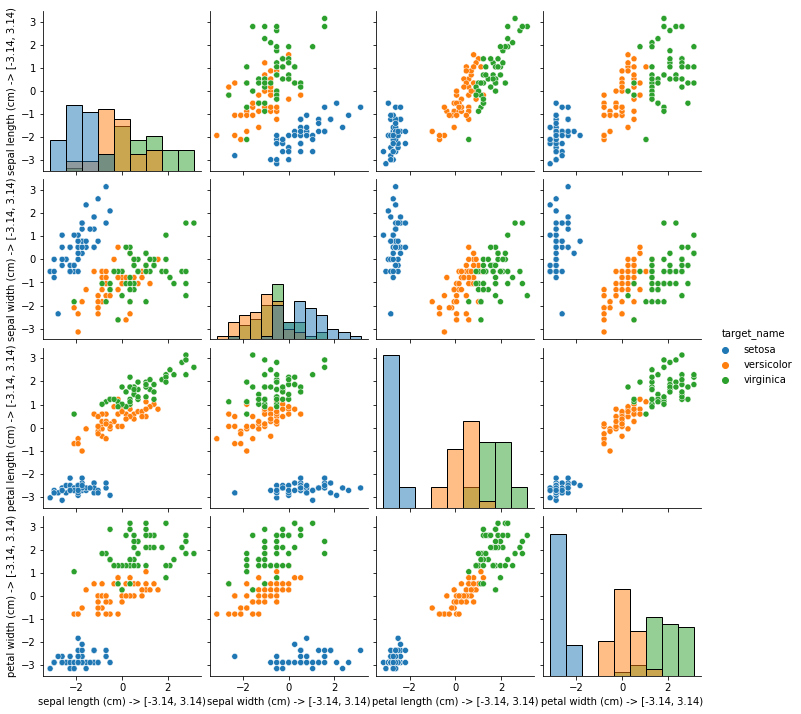

In [3]:
from classifiers.datasets.sklearn import SklearnDataset

ds = SklearnDataset(loader='iris', feature_range=(-np.pi, np.pi))
ds.plot()

In [241]:
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap
from qiskit.circuit.library import ZZFeatureMap
from classifiers.quantum.qasvm import STATEVECTOR_INSTANCE, QuantumKernel
X, y = ds.sample(2**6, return_X_y=True)
X = X[:, :2]
feature_map = ZZFeatureMap(2, reps=5)#MultilayerCircuit9FeatureMap(2)
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=STATEVECTOR_INSTANCE)
kernel_matrix = quantum_kernel.evaluate(X, X)


In [242]:
from sklearn.datasets import make_blobs
#X, y = make_blobs(100, 2, centers=3, random_state=1)
#plt.scatter(X[:, 0], X[:, 1], c=y)

In [243]:
from classifiers.datasets.sklearn import SklearnDataset

def make_kernel(data1, data2):
    K = np.empty((len(data1), len(data2)))
    for i, d1 in enumerate(data1):
        for j, d2 in enumerate(data2):
            K[i, j] = np.exp(-1*(d1-d2).T @ (d1-d2))
    return K
#kernel_matrix = make_kernel(X, X)
C=1

In [244]:
from cvxopt import matrix, solvers

M = kernel_matrix.shape[0]
P = matrix(kernel_matrix+np.eye(M)/C)
q = matrix(np.zeros(M))
G = matrix(-np.eye(M))
h = matrix(np.zeros(M))
A = matrix(np.ones(M), (1, M))
b = matrix(1.0)

sol = solvers.qp(P, q, G, h, A, b)
alpha = np.asarray(sol['x']).flatten()


     pcost       dcost       gap    pres   dres
 0:  1.4175e-01 -8.7735e-01  7e+01  8e+00  8e+00
 1:  1.4507e-01 -8.4028e-01  1e+00  4e-02  4e-02
 2:  1.4633e-01  7.6839e-02  7e-02  6e-17  2e-15
 3:  1.4214e-01  1.3287e-01  9e-03  2e-16  4e-16
 4:  1.4126e-01  1.4025e-01  1e-03  2e-16  3e-16
 5:  1.4109e-01  1.4099e-01  9e-05  8e-17  3e-16
 6:  1.4106e-01  1.4106e-01  6e-06  2e-16  3e-16
 7:  1.4106e-01  1.4106e-01  3e-07  1e-16  3e-16
 8:  1.4106e-01  1.4106e-01  3e-08  6e-16  3e-16
Optimal solution found.


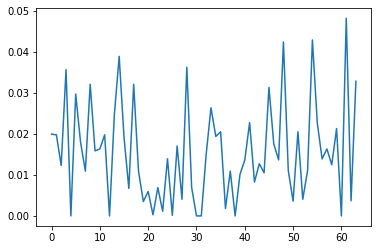

In [245]:
plt.plot(alpha)

In [246]:
sv_mask = np.where(alpha>0.01*np.mean(alpha), True, False)

def get_rho(data, training_data, alpha):
    # kernel_matrix =  make_kernel(data, training_data)
    kernel_matrix = quantum_kernel.evaluate(data, training_data)
    return np.matmul(kernel_matrix, alpha)
rho = np.mean(get_rho(X[sv_mask], X, alpha))
rho

rho_s = get_rho(X, X, alpha)
sv_mask = np.where(rho_s<rho, True, False)

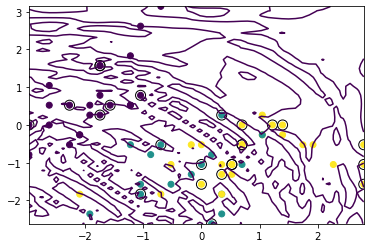

In [247]:
feature0 = np.linspace(min(X[:, 0]), max(X[:, 0]), 50)
feature1 = np.linspace(min(X[:, 1]), max(X[:, 1]), 50)
F1, F2 = np.meshgrid(feature0, feature1)
Z = get_rho(list(zip(F1.flatten(), F2.flatten())), X, alpha).reshape(F1.shape)
plt.contour(F1, F2, Z, levels=[rho])
plt.scatter(X[:, 0], X[:, 1], c=y[:])
plt.scatter(X[sv_mask, 0], X[sv_mask, 1], marker='o', color='none', edgecolor='k', s=100)

In [218]:
def make_intermediate_matrix(data, n_lambda):
    set_of_data = np.empty((data.shape[0], data.shape[0], n_lambda, data.shape[1]))
    for i in range(len(data)):
        for j in range(len(data)):
            for ind, lmda in enumerate(np.linspace(0, 1, n_lambda)):
                new_data = lmda*data[i]+(1-data)[j]
                set_of_data[i, j, ind, :] = new_data
    return set_of_data
intermediate_data = make_intermediate_matrix(X[~sv_mask], 10)
get_rho(intermediate_data.reshape(-1, 2), X[sv_mask], alpha)

QiskitError: 'Keyboard interrupt in parallel_map.'

In [306]:
from classifiers.quantum.qasvm import SoftQASVM
from classifiers.quantum.quantum_circuits import NqSVM_circuit
from classifiers.quantum.ansatz import Circuit10, MultilayerCircuit9FeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit import transpile
_X = np.random.randn(2**13, 10)
_y = np.random.randn(2**13)
feature_map = MultilayerCircuit9FeatureMap(10)
qc = NqSVM_circuit(13, 10, 2)
qc.UD_encode(feature_map, feature_map_params=None, N=None, training_data=_X, training_label=np.where(_y>0, 1, 0), reg='i')
qc.UD_encode(feature_map, feature_map_params=None, N=None, training_data=_X, training_label=np.where(_y>0, 1, 0), reg='j')

qasm_string = transpile(qc, basis_gates=['rx', 'ry', 'rz', 'cx']).qasm()



In [307]:
import pennylane as qml

device = qml.device('lightning.qubit', wires=qc.num_qubits)
my_loader = qml.from_qasm(qasm_string)

def find_qubit_index(reg_name, qc):
    _l = []
    for qubit in list(qc._reg_dict[reg_name]):
        _l.append(qc.qubits.index(qubit))
    return _l

@qml.qnode(device)
def circuit(params):
    qml.BasicEntanglerLayers(weights=params, wires=find_qubit_index('i', qc))
    qml.BasicEntanglerLayers(weights=params, wires=find_qubit_index('j', qc))
    my_loader(wires=device.wires)
    qml.Hadamard(wires=find_qubit_index('a', qc))
    for xi, xj in zip(find_qubit_index('xi', qc), find_qubit_index('xj', qc)):
        qml.CSWAP(wires=find_qubit_index('a', qc)+[xi, xj])
    qml.Hadamard(wires=find_qubit_index('a', qc))
    return qml.expval(qml.PauliZ(wires=find_qubit_index('a', qc)) @ qml.PauliZ(wires=find_qubit_index('yi', qc)) @ qml.PauliZ(wires=find_qubit_index('yj', qc)))

param_shape = qml.BasicEntanglerLayers.shape(2, 13)
params = qml.numpy.random.random(param_shape)
# qml.draw(circuit)()
circuit(params)

MemoryError: Unable to allocate 8.00 PiB for an array with shape (562949953421312,) and data type complex128

In [298]:
def find_qubit_index(reg_name, qc):
    _l = []
    for qubit in list(qc._reg_dict[reg_name]):
        _l.append(qc.qubits.index(qubit))
    return _l